In [1]:
import qsample as qs
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import pymatching
import random

# Helpers

In [2]:
def dem2matrices(dem, n_detectors=20):
    txt = dem.split('\n')[1:-1]
    dims = len(txt)
    errors = np.zeros(dims)
    err_locs = np.zeros((dims, n_detectors))

    for i in range(dims):
        errors[i] = re.findall('\d?\.?\d+e?\-?\d+', txt[i])[0]
        for j in re.findall('D\d', txt[i]):
            err_locs[i, int(j[1])]=1

    return errors, err_locs

In [3]:
class node:
    
    def __init__(self, circuit):
        self.circuit = circuit
        self.zero = None
        self.one = None
        
    def fail_path(self):
        fails= []
        path = []
        if self.one==1:
            path = [1]
            fails.append(path)
        else:
            for p in self.one.fail_path():
                p.append(1)
                fails.append(p)
        if self.zero!=0:
            for p in self.zero.fail_path():
                p.append(0)
                fails.append(p)
        return fails
    
    def fail_paths(self):
        p = []
        circs = []
        for j in self.fail_path():
            p.append(j[::-1])
            
        for j in p:
            node = self
            circ = node.circuit
            for i in j[:-1]:
                if i == 1:
                    circ+=node.one.circuit
                    node = node.one
                if i == 0:
                    circ+=node.zero.circuit
                    node = node.zero
            circs.append(circ)
        
        return p, circs

# QSample

In [4]:
C1 = qs.Circuit([{"init": {0, 1, 2, 3, 4}},
                       {"X": {0, 2, 3}},
                       {"CNOT": {(0, 3)}},
                       {"measure": {3}}])


C2 =  qs.Circuit([{"CNOT": {(0, 2)}},
                       {"H": {2, 3}},
                       {"CNOT": {(4, 3)}},
                      {"H": {2, 3}},
                      {"CNOT": {(2, 4)}},
                       {"measure": {4}}])


C3 = qs.Circuit([{"CNOT": {(2, 1)}},
                       {"measure": {1}}])


C4 = qs.Circuit([{"CNOT": {(3, 1)}},
                       {"measure": {1}}])

steane0 = qs.Protocol(fault_tolerant=False)

steane0.add_nodes_from(['C1', 'C2', 'C3', 'C4'], circuits=[C1, C2, C3, C4])
steane0.add_edge('START', 'C1', check='True')
steane0.add_edge('C1', 'C4', check='C1[-1]==0')
steane0.add_edge('C1', 'C2', check='C1[-1]==1')
steane0.add_edge('C2', 'C3', check='C2[-1]==1')
steane0.add_edge('C3', 'FAIL', check='C3[-1]==1')
steane0.add_edge('C4', 'FAIL', check='C4[-1]==1')

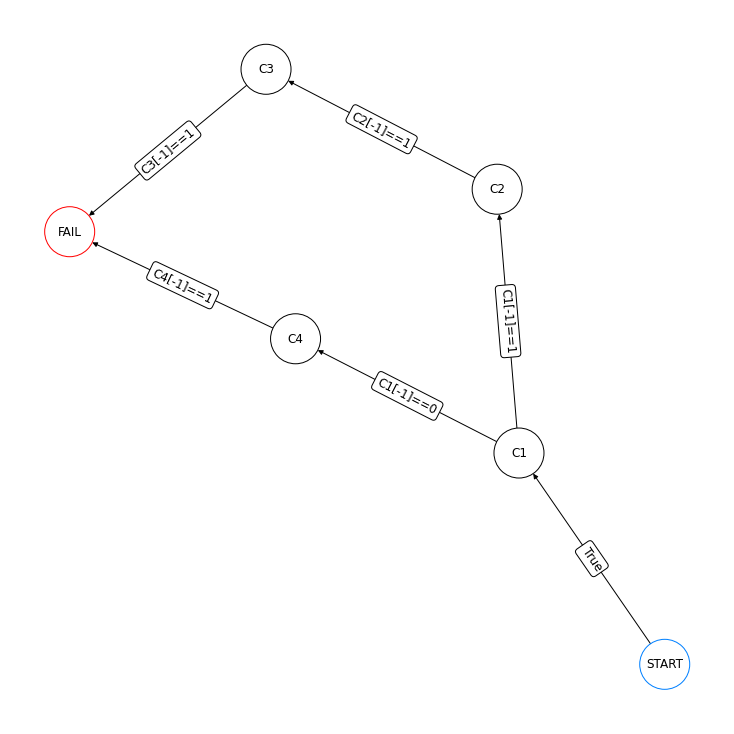

In [5]:
steane0.draw(figsize=(10,10))

In [6]:
err_model = qs.noise.E1
q = [1e-5, 1e-3, 1e-1, 0.5]
err_params = {'q': q}

In [7]:
begin = time.time()
ss_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StabilizerSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(1000)
end = time.time()
qsample_time = end-begin

p=('1.00e-01',):   0%|          | 0/1000 [00:00<?, ?it/s]

## STIM

In [8]:
C1 = """X 0 2 3\nDEPOLARIZE1({q}) 0 2 3\n
                    CNOT 0 3\nDEPOLARIZE2({q}) 0 3\n
                    M 3
                    DETECTOR rec[-1]
                    TICK
                    """
C2 = """CNOT 0 2\nDEPOLARIZE2({q}) 0 2\n
                    H 2 3 \nDEPOLARIZE1({q}) 2 3\n
                    CNOT 4 3\nDEPOLARIZE2({q}) 4 3\n
                    H 2 3 \nDEPOLARIZE1({q}) 2 3\n
                    CNOT 2 4\nDEPOLARIZE2({q}) 2 4\n
                    M 4
                    DETECTOR rec[-1]
                    TICK
                    """

C3 = """CNOT 2 1\nDEPOLARIZE2({q}) 2 1\n
                    M 1
                    DETECTOR rec[-1]
                    TICK
                    """

C4 = """CNOT 3 1\nDEPOLARIZE2({q}) 3 1\n
                    M 1
                    DETECTOR rec[-1]
                    TICK
                    """

In [9]:
c3 = node(C3)
c3.zero = 0
c3.one = 1

c4 = node(C4)
c4.zero = 0
c4.one = 1

c2 = node(C2)
c2.zero = 0
c2.one = c3

c1 = node(C1)
c1.zero = c4
c1.one = c2

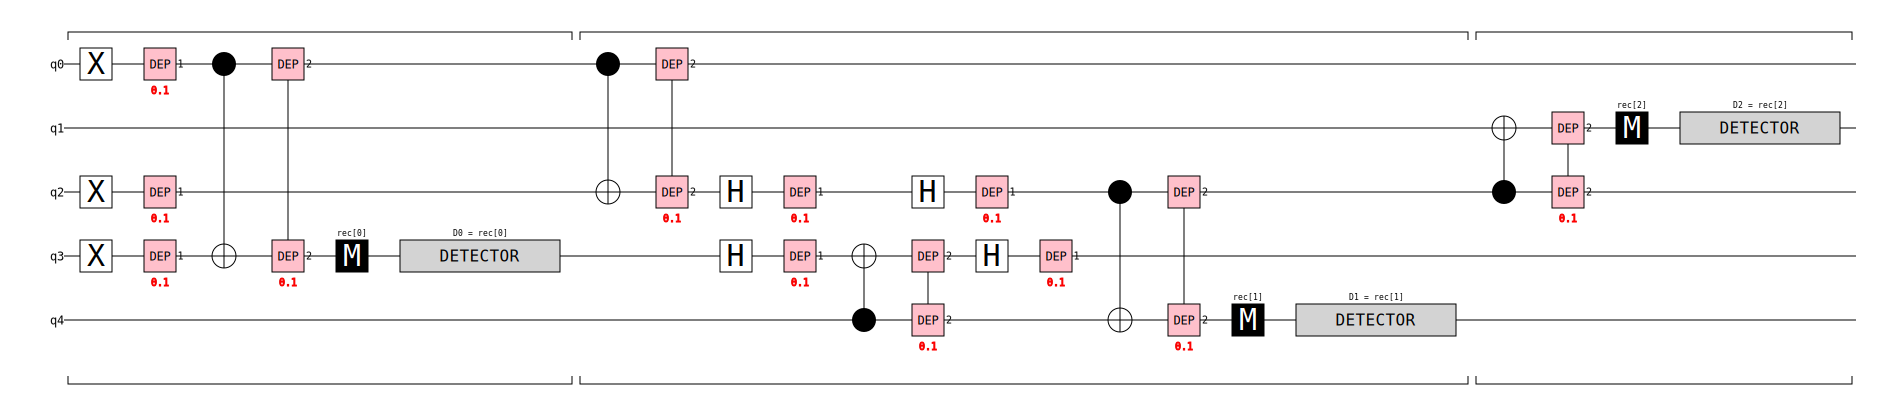

In [10]:
i = 0.1
circuit = stim.Circuit(c1.fail_paths()[1][0].format(q=i))
circuit.diagram('timeline-svg')

In [11]:
C = stim.Circuit("""X 0\nM 0\nDETECTOR rec[-1]""")

In [12]:
dem = circuit.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.0904293) D0
    error(0.0904293) D0 D1 D2
    error(0.0778271) D1
    error(0.240251) D1 D2
    error(0.0778271) D2
''')


In [13]:
err_total = np.zeros(len(q))
begin = time.time()
paths, circuits = c1.fail_paths()
for p in range(len(paths)):
    circuit = stim.Circuit(circuits[p].format(q=0.1)) #arbitrary error rate
    dem = circuit.detector_error_model()
    errors, errloc = dem2matrices(repr(dem),len(paths[p]))
    err = len(errors)

    # Binary matrix generation
    result = np.stack((np.arange(2**err),) * err, axis=1)
    divide = np.stack((2**np.arange(err)[::-1],)*2**err, axis=0) 
    result=result//divide%2      

    # Find error combinations that cause desired output
    result=result[np.all(np.dot(result,errloc)%2==paths[p], axis=1)]


    for i in range(len(q)):
        circuit = stim.Circuit(circuits[p].format(q=q[i]))
        dem = circuit.detector_error_model()
        errors, errloc = dem2matrices(repr(dem),len(paths[p]))
        err_total[i]+= np.sum(np.prod(errors*result+(1-errors)*(1-result), axis=1))
end = time.time()
stim_time = end-begin

# Comparison

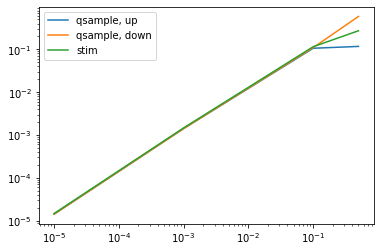

In [14]:
plt.plot(q, ss_sam.stats()[0], label = 'qsample, up')
plt.plot(q, ss_sam.stats()[2], label = 'qsample, down')
plt.plot(q, err_total, label = 'stim')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [15]:
print("QSample time: {:.3}s".format(qsample_time))
print("STIM time: {:.3}s".format(stim_time))

QSample time: 0.549s
STIM time: 0.00226s
